In [86]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import LSTM, LeakyReLU, CuDNNLSTM
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [99]:
with h5py.File(''.join(['data/allcoin2015to2017_wf.h5']), 'r') as hf:
    test_inputs = hf['test_inputs'].value
    test_outputs = hf['test_outputs'].value
    test_input_times = hf['test_input_times'].value
    test_output_times = hf['test_output_times'].value
    original_test_inputs = hf['original_test_inputs'].value
    original_test_outputs = hf['original_test_outputs'].value
    original_datas= hf['original_datas'].value
    inputs = hf['inputs'].value
    outputs = hf['outputs'].value

In [4]:
step_size = test_inputs.shape[1]
units= 50
second_units = 30
batch_size = 8
nb_features = test_inputs.shape[2]
epochs = 50
output_size=1

In [68]:
result_file = 'allcoin2015to2017_WF_CNN_2.csv'
df = pd.read_csv(result_file)
zero_indexes = [i for i,e in enumerate(df.epoch) if e==0]
zero_indexes
df['partition'] = -1
for z in zero_indexes:
    df.partition += [0]*(z) + [1] * (len(df)-z )

df.loc[df.val_loss == df.val_loss.min(), :]
df.groupby('partition').describe()['val_loss']

,count,mean,std,min,25%,50%,75%,max
partition,,,,,,,,
0,23.0,0.000427,0.000049,0.000315,0.000401,0.000412,0.000463,0.000508
1,11.0,0.000020,0.000007,0.000014,0.000016,0.000018,0.000021,0.000034
2,17.0,0.000105,0.000040,0.000049,0.000083,0.000098,0.000124,0.000198
3,40.0,0.000049,0.000055,0.000006,0.000013,0.000032,0.000056,0.000251
4,27.0,0.000012,0.000007,0.000003,0.000008,0.000010,0.000015,0.000030
5,11.0,0.000135,0.000045,0.000011,0.000134,0.000140,0.000160,0.000181
6,11.0,0.000876,0.000105,0.000606,0.000852,0.000917,0.000936,0.000982
7,11.0,0.005550,0.000099,0.005369,0.005514,0.005558,0.005602,0.005712
8,11.0,0.000028,0.000012,0.000018,0.000020,0.000023,0.000030,0.000057


In [40]:
import os
file_start= 'allcoin2015to2017_WF_CNN_2'
for root, dirs, files in os.walk("."):  
    for filename in files:
        if filename[:len(file_start)] == file_start and 'csv' in filename:
            print(filename)

allcoin2015to2017_WF_CNN_2.csv


In [109]:
model = Sequential()
    # 2 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.2))

model.add(Conv1D( strides=4, filters=1, kernel_size=16))

'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))


# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''
model.load_weights('weights/allcoin2015to2017_WF_CNN_2partition_11.hdf5')
model.compile(loss='mse', optimizer='adam')

In [116]:
test_inputs

array([[[ 5.08845753,  5.79730619,  3.63272746,  4.3039661 ],
        [ 5.09582317,  5.84995571,  3.63342788,  4.28445653],
        [ 5.07669878,  5.80768391,  3.65259413,  4.28445654],
        ..., 
        [ 5.5370005 ,  6.41386149,  3.81620064,  4.74807096],
        [ 5.5509778 ,  6.33608138,  3.82237539,  4.75626852],
        [ 5.55281248,  6.30782847,  3.82854706,  4.75843819]],

       [[ 5.09582317,  5.84995571,  3.63342788,  4.28445653],
        [ 5.07669878,  5.80768391,  3.65259413,  4.28445654],
        [ 5.08845753,  5.84699669,  3.67973854,  4.32521475],
        ..., 
        [ 5.5509778 ,  6.33608138,  3.82237539,  4.75626852],
        [ 5.55281248,  6.30782847,  3.82854706,  4.75843819],
        [ 5.54320545,  6.33608138,  3.83163752,  4.75843819]],

       [[ 5.07669878,  5.80768391,  3.65259413,  4.28445654],
        [ 5.08845753,  5.84699669,  3.67973854,  4.32521475],
        [ 5.08426232,  5.80768391,  3.65928955,  4.29590066],
        ..., 
        [ 5.55281248,  6

In [110]:
predicted = model.predict(test_inputs)

In [111]:
scaler = StandardScaler()
scaler.fit(original_datas)
predicted_inverted = []
for i in range(len(predicted)):
    predicted_inverted.append(scaler.inverse_transform(predicted[i,:]))
predicted_inverted = np.array(predicted_inverted)

In [113]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = pd.to_datetime(test_input_times[:,:,0].reshape(-1),unit='s')
ground_true_df['value'] = original_test_inputs[:,:,0].reshape(-1)
ground_true_df.set_index('times')
ground_true_df = ground_true_df.drop_duplicates(subset=['times','value'])
ground_true_df.head()

,times,value
0,2017-12-16 08:55:00,17860.000001
1,2017-12-16 09:00:00,17883.000000
2,2017-12-16 09:05:00,17823.282001
3,2017-12-16 09:10:00,17860.000000
4,2017-12-16 09:15:00,17846.900000


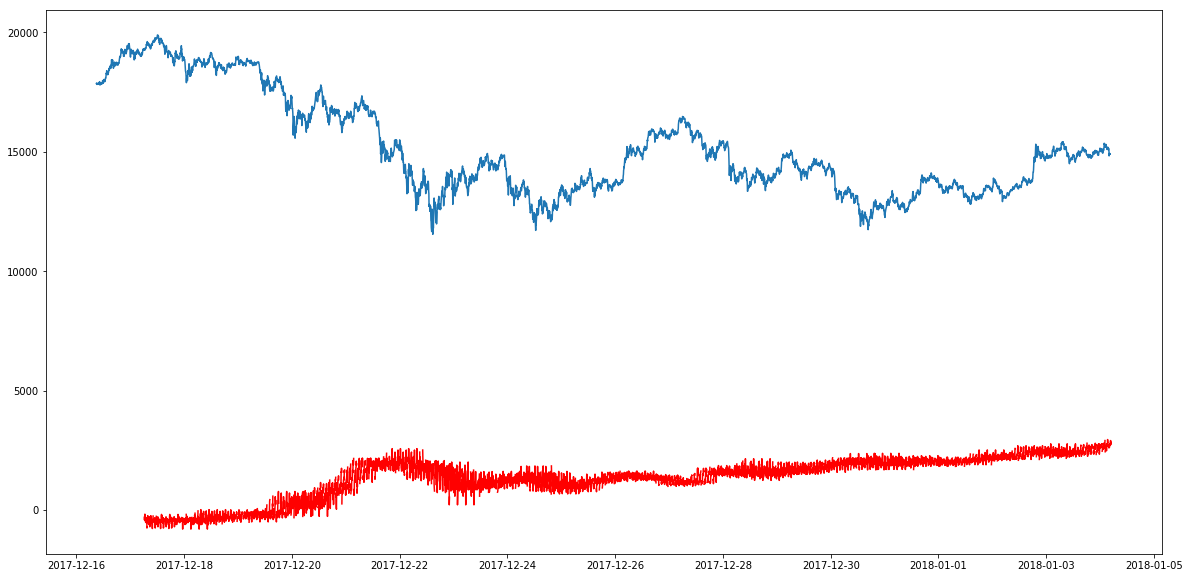

In [115]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')

for i in range(len(test_output_times)):
    if i%16 == 0:
        prediction_df = pd.DataFrame()
        prediction_df['times']= pd.to_datetime(test_output_times[i,:,:].reshape(-1),unit='s')
        prediction_df['value']= predicted_inverted[i,:,:].reshape(-1)
        plt.plot(prediction_df.times,prediction_df.value,'r', label='Predicted')
        
# plt.legend(loc='upper left')
plt.savefig('result/allcoin2015to2017_WF_CNN_2_scale_on_whole.png')
plt.show()


In [80]:
pd.to_datetime(test_output_times[i,:,:].reshape(-1),unit='s')

DatetimeIndex(['2017-12-17 06:15:00', '2017-12-17 06:20:00',
               '2017-12-17 06:25:00', '2017-12-17 06:30:00',
               '2017-12-17 06:35:00', '2017-12-17 06:40:00',
               '2017-12-17 06:45:00', '2017-12-17 06:50:00',
               '2017-12-17 06:55:00', '2017-12-17 07:00:00',
               '2017-12-17 07:05:00', '2017-12-17 07:10:00',
               '2017-12-17 07:15:00', '2017-12-17 07:20:00',
               '2017-12-17 07:25:00', '2017-12-17 07:30:00'],
              dtype='datetime64[ns]', freq=None)